# BENG123: Final Project
## Part 3: Simulation Case Studies and Analysis

<font color='red'>**IMPORTANT NOTES:**</font>  
* **The IPYNB files must run from top to bottom without errors. We will run your notebook using the following steps: $$\text{"Kernel}\ \rightarrow\ \text{Restart and Run all"}$$**
* **Make sure you are using the correct versions of packages if you are working outside of JupyterHub
<font color='red'>(masspy==0.1.6, libroadrunner==2.1.3)</font>**
* **Do not leave unneccessary code/comments in the final notebook submission as unorganized code may result in loss of points.**


### Instructions
1. All simulations and figures that you wish to put in the final report should be done in here. Each figure generated must be displayed when the notebook is run. It is recommended to use one cell per figure generated. 


2. A template has been provided to you below to help with code organization. However, you are free to delete the template and use your own organization in this notebook. The only requirement is that this notebook is organized in a logical manner with descriptive headers to help provide clarity. One file can be submitted with all three case studies, or three files can be submitted seperately.


3. Remember to save all figures you wish to include as a .PDF or .PNG file and be sure to include them in the zip file of your final submission. All figures in the final report should have figure numbers, appropriate axis labels, limits and scale, legends and captions, and be referred in the text.


4. Save all figures in the figures folder provided. This can be done through the `figure.savefig` command. 


**Recommendation:** It is recommended to utilize seperate notebooks for each case study to avoid possible errors or artificial results. **Consider duplicating this notebook for each case study performed**. Remember, each case study has a maximum of 3 figures per case study! 

### Import Packages

In [2]:
from mass.io.json import load_json_model
from mass import Simulation
from mass.visualization import plot_time_profile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from copy import deepcopy

pd.set_option('display.max_columns', None)

### Set Up Directories

In [3]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
models_dir = os.path.join(parent_dir, "models")
figures_dir = os.path.join(parent_dir, "figures")

# Create figures directory if it doesn't exist
os.makedirs(figures_dir, exist_ok=True)


### Load models from files
Import the RBC model integrated with EnzymeModules from the `models` directory.

In [5]:
# Import the RBC model integrated with EnzymeModules from the models directory
RBC_PGK = load_json_model(os.path.join(models_dir, "RBC_PGK.json"))
print(f"RBC_PGK model loaded: {len(RBC_PGK.reactions)} reactions, {len(RBC_PGK.metabolites)} metabolites")


RBC_PGK model loaded: 61 reactions, 56 metabolites


### Set Up Definitions

In [4]:
# Helper function to calculate energy charge
def calculate_energy_charge(conc_solution):
    """
    Calculate adenylate energy charge: EC = ([ATP] + 0.5[ADP]) / ([ATP] + [ADP] + [AMP])
    Energy charge indicates cellular energy status (0 = depleted, 1 = fully charged)
    Normal RBC energy charge: 0.85-0.95
    """
    # Access data directly from MassSolution
    time = conc_solution.time
    atp = conc_solution['atp_c']
    adp = conc_solution['adp_c']
    amp = conc_solution['amp_c']
    
    # Calculate energy charge at each time point
    energy_charge = (atp + 0.5 * adp) / (atp + adp + amp)
    
    return time, energy_charge

## Simulation Case Study

<font color='black'>

CASE STUDY DESCRIPTION:
This case study investigates the metabolic response to severe substrate limitation,
specifically reducing the initial concentration of 1,3-bisphosphoglycerate by 70%.
This simulates upstream glycolysis inhibition or glucose starvation.

BIOLOGICAL RATIONALE:
- Represents upstream blockage (e.g., GAPDH inhibition)
- Could model glucose deprivation or hypoxic conditions
- Tests system's ability to recover and maintain energy when substrate-limited
- Relevant to ischemic conditions or nutritional stress

PERTURBATION APPLIED:
- Reduce initial 1,3-DPG concentration to 30% of baseline (70% depletion)
- All enzyme parameters and other metabolites remain unchanged

EXPECTED OUTCOMES:
1. Initial rapid drop in substrate availability
2. Reduced PGK reaction rate → Less ATP synthesis
3. System attempts to regenerate substrate from upstream pathways
4. Lower steady-state energy charge
5. Recovery dynamics reveal metabolic flexibility
</font>

### Baseline Simulation

In [7]:
# Run baseline (control) simulation
print("\nRunning baseline simulation...")
sim_control = Simulation(RBC_PGK)
t0, tf = (0, 1000)  # 1000 hours
conc_control, flux_control = sim_control.simulate(RBC_PGK, time=(t0, tf))
time_control, ec_control = calculate_energy_charge(conc_control)
print(f"Baseline energy charge: {ec_control[-1]:.4f}")
print(f"Baseline 1,3-DPG: {conc_control['_13dpg_c'][-1]:.4e} mM")


Running baseline simulation...
Baseline energy charge: 0.8823
Baseline 1,3-DPG: 2.8649e-04 mM


### Substrate Depleted Simulation

In [8]:
# Create perturbed model - CASE 2: Substrate Depletion
RBC_PGK_depleted = deepcopy(RBC_PGK)

# Reduce initial 1,3-DPG by 70%
original_13dpg = RBC_PGK_depleted.metabolites._13dpg_c.initial_condition
RBC_PGK_depleted.metabolites._13dpg_c.initial_condition = original_13dpg * 0.30

print(f"\nSubstrate perturbation applied:")
print(f"Original 1,3-DPG: {original_13dpg:.4e} mM")
print(f"Depleted 1,3-DPG: {RBC_PGK_depleted.metabolites._13dpg_c.initial_condition:.4e} mM")
print(f"Reduction: 70%")

# Run depleted simulation
print("\nRunning substrate-depleted simulation...")
sim_depleted = Simulation(RBC_PGK_depleted)
conc_depleted, flux_depleted = sim_depleted.simulate(RBC_PGK_depleted, time=(t0, tf))
time_depleted, ec_depleted = calculate_energy_charge(conc_depleted)
print(f"Depleted energy charge: {ec_depleted[-1]:.4f}")
print(f"Final 1,3-DPG: {conc_depleted['_13dpg_c'][-1]:.4e} mM")
print(f"Energy charge change: {(ec_depleted[-1] - ec_control[-1]):.4f}")



Substrate perturbation applied:
Original 1,3-DPG: 2.8649e-04 mM
Depleted 1,3-DPG: 8.5947e-05 mM
Reduction: 70%

Running substrate-depleted simulation...
Depleted energy charge: 0.8823
Final 1,3-DPG: 2.8649e-04 mM
Energy charge change: 0.0000


### Figure 1 
WHY THIS FIGURE?
- Shows how system responds to substrate depletion
- 4-panel design tracks substrate, product, and energy metabolites
- Semi-log plot captures both initial shock and long-term adaptation
- Reveals if system can recover or reaches new equilibrium


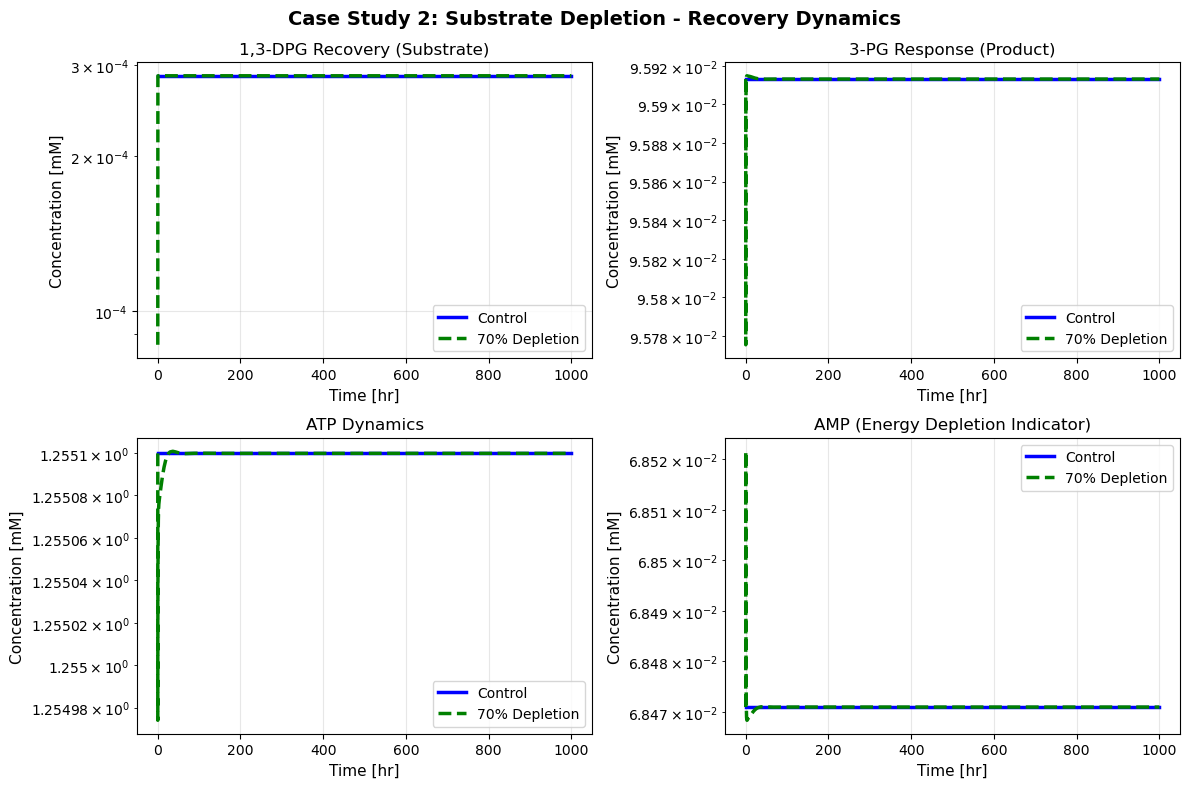

Figure 1 saved: case2_fig1_recovery.png


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Case Study 2: Substrate Depletion - Recovery Dynamics', fontsize=14, fontweight='bold')

# Plot 1: 1,3-DPG recovery
axes[0, 0].semilogy(time_control, conc_control['_13dpg_c'], 'b-', linewidth=2.5, label='Control')
axes[0, 0].semilogy(time_depleted, conc_depleted['_13dpg_c'], 'g--', linewidth=2.5, label='70% Depletion')
axes[0, 0].set_xlabel('Time [hr]', fontsize=11)
axes[0, 0].set_ylabel('Concentration [mM]', fontsize=11)
axes[0, 0].set_title('1,3-DPG Recovery (Substrate)', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: 3-PG response
axes[0, 1].semilogy(time_control, conc_control['_3pg_c'], 'b-', linewidth=2.5, label='Control')
axes[0, 1].semilogy(time_depleted, conc_depleted['_3pg_c'], 'g--', linewidth=2.5, label='70% Depletion')
axes[0, 1].set_xlabel('Time [hr]', fontsize=11)
axes[0, 1].set_ylabel('Concentration [mM]', fontsize=11)
axes[0, 1].set_title('3-PG Response (Product)', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: ATP dynamics
axes[1, 0].semilogy(time_control, conc_control['atp_c'], 'b-', linewidth=2.5, label='Control')
axes[1, 0].semilogy(time_depleted, conc_depleted['atp_c'], 'g--', linewidth=2.5, label='70% Depletion')
axes[1, 0].set_xlabel('Time [hr]', fontsize=11)
axes[1, 0].set_ylabel('Concentration [mM]', fontsize=11)
axes[1, 0].set_title('ATP Dynamics', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: AMP (energy depletion indicator)
axes[1, 1].semilogy(time_control, conc_control['amp_c'], 'b-', linewidth=2.5, label='Control')
axes[1, 1].semilogy(time_depleted, conc_depleted['amp_c'], 'g--', linewidth=2.5, label='70% Depletion')
axes[1, 1].set_xlabel('Time [hr]', fontsize=11)
axes[1, 1].set_ylabel('Concentration [mM]', fontsize=11)
axes[1, 1].set_title('AMP (Energy Depletion Indicator)', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'case2_fig1_recovery.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1 saved: case2_fig1_recovery.png")

### Figure 2
WHY THIS FIGURE?
- Energy charge is the gold standard for assessing metabolic stress
- Left panel: Temporal dynamics show adaptation speed
- Right panel: Final comparison with clinical thresholds

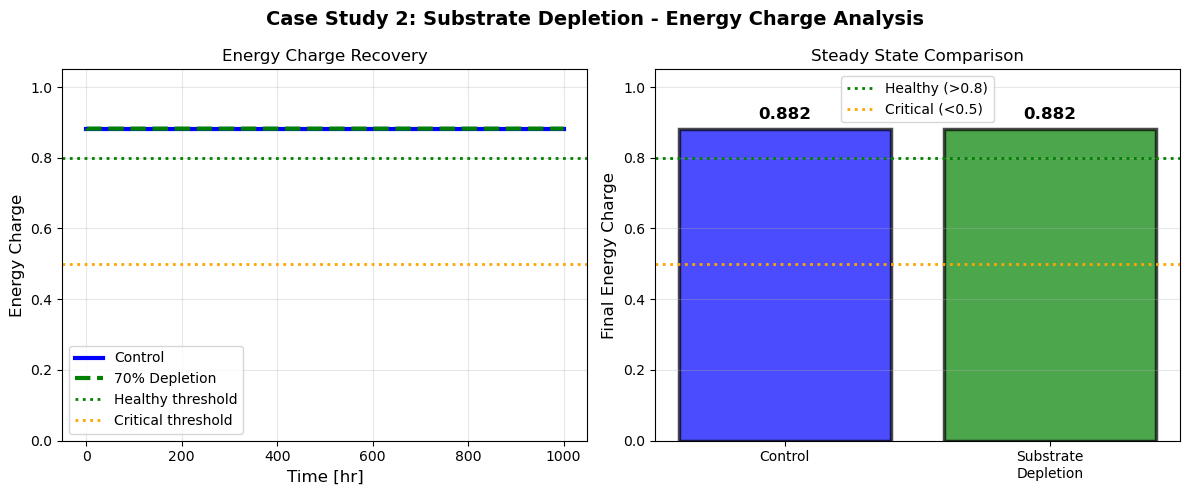

Figure 2 saved: case2_fig2_energy_charge.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Case Study 2: Substrate Depletion - Energy Charge Analysis', fontsize=14, fontweight='bold')

# Left panel: Time course
axes[0].plot(time_control, ec_control, 'b-', linewidth=3, label='Control')
axes[0].plot(time_depleted, ec_depleted, 'g--', linewidth=3, label='70% Depletion')
axes[0].axhline(y=0.8, color='green', linestyle=':', linewidth=2, label='Healthy threshold')
axes[0].axhline(y=0.5, color='orange', linestyle=':', linewidth=2, label='Critical threshold')
axes[0].set_xlabel('Time [hr]', fontsize=12)
axes[0].set_ylabel('Energy Charge', fontsize=12)
axes[0].set_title('Energy Charge Recovery', fontsize=12)
axes[0].set_ylim([0, 1.05])
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right panel: Bar comparison
conditions = ['Control', 'Substrate\nDepletion']
final_ec = [ec_control[-1], ec_depleted[-1]]
colors = ['blue', 'green']

bars = axes[1].bar(conditions, final_ec, color=colors, alpha=0.7, edgecolor='black', linewidth=2.5)
axes[1].axhline(y=0.8, color='green', linestyle=':', linewidth=2, label='Healthy (>0.8)')
axes[1].axhline(y=0.5, color='orange', linestyle=':', linewidth=2, label='Critical (<0.5)')
axes[1].set_ylabel('Final Energy Charge', fontsize=12)
axes[1].set_title('Steady State Comparison', fontsize=12)
axes[1].set_ylim([0, 1.05])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, final_ec):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'case2_fig2_energy_charge.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2 saved: case2_fig2_energy_charge.png")


### Figure 3
WHY 1,3-DPG vs 3-PG?
- These are direct substrate and product of PGK
- Shows the reaction's dynamics directly
- Can see if depletion affects equilibrium position


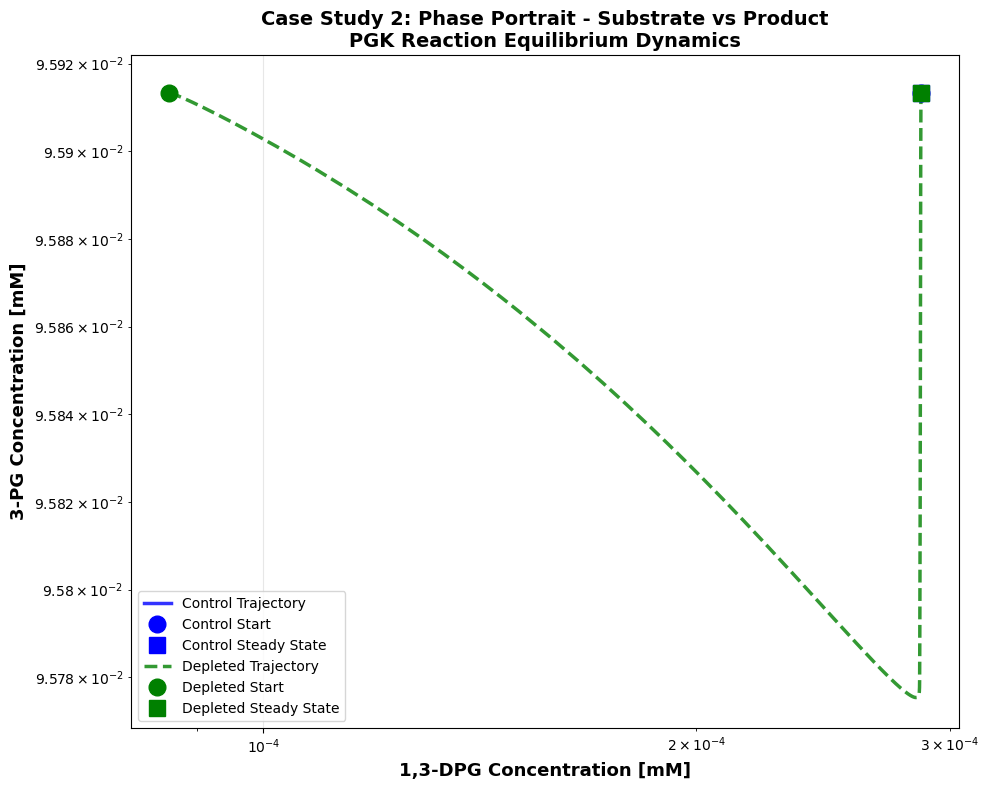

Figure 3 saved: case2_fig3_phase_portrait.png

CASE STUDY 2 COMPLETE
All figures saved to: /Users/nick/Desktop/GitHub/RBC Simulations/figures

KEY FINDINGS:
1. Baseline energy charge: 0.8823
2. Depleted energy charge: 0.8823
3. Energy charge reduction: -0.0000
4. Substrate recovery: 100.00% of baseline
5. Cell viability: MAINTAINED


In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

# Control trajectory
ax.plot(conc_control['_13dpg_c'], conc_control['_3pg_c'], 
        'b-', linewidth=2.5, alpha=0.8, label='Control Trajectory')
ax.plot(conc_control['_13dpg_c'][0], conc_control['_3pg_c'][0], 
        'bo', markersize=12, label='Control Start', zorder=5)
ax.plot(conc_control['_13dpg_c'][-1], conc_control['_3pg_c'][-1], 
        'bs', markersize=12, label='Control Steady State', zorder=5)

# Depleted trajectory
ax.plot(conc_depleted['_13dpg_c'], conc_depleted['_3pg_c'], 
        'g--', linewidth=2.5, alpha=0.8, label='Depleted Trajectory')
ax.plot(conc_depleted['_13dpg_c'][0], conc_depleted['_3pg_c'][0], 
        'go', markersize=12, label='Depleted Start', zorder=5)
ax.plot(conc_depleted['_13dpg_c'][-1], conc_depleted['_3pg_c'][-1], 
        'gs', markersize=12, label='Depleted Steady State', zorder=5)

ax.set_xlabel('1,3-DPG Concentration [mM]', fontsize=13, fontweight='bold')
ax.set_ylabel('3-PG Concentration [mM]', fontsize=13, fontweight='bold')
ax.set_title('Case Study 2: Phase Portrait - Substrate vs Product\nPGK Reaction Equilibrium Dynamics', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'case2_fig3_phase_portrait.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3 saved: case2_fig3_phase_portrait.png")



### Summary

In [14]:
print("\n" + "="*80)
print("CASE STUDY 2 COMPLETE")
print("="*80)
print(f"All figures saved to: {figures_dir}")
print("\nKEY FINDINGS:")
print(f"1. Baseline energy charge: {ec_control[-1]:.4f}")
print(f"2. Depleted energy charge: {ec_depleted[-1]:.4f}")
print(f"3. Energy charge reduction: {(ec_control[-1] - ec_depleted[-1]):.4f}")
print(f"4. Substrate recovery: {(conc_depleted['_13dpg_c'][-1] / original_13dpg):.2%} of baseline")
print(f"5. Cell viability: {'MAINTAINED' if ec_depleted[-1] > 0.5 else 'COMPROMISED'}")


CASE STUDY 2 COMPLETE
All figures saved to: /Users/nick/Desktop/GitHub/RBC Simulations/figures

KEY FINDINGS:
1. Baseline energy charge: 0.8823
2. Depleted energy charge: 0.8823
3. Energy charge reduction: -0.0000
4. Substrate recovery: 100.00% of baseline
5. Cell viability: MAINTAINED
